In [1]:
# test of the raster creation

import sys
import os
import pandas as pd
import xarray as xr
import numpy as np

# Add the path to your custom library
custom_library_path = os.path.abspath('/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/cleaner_version/util/wind_map')
sys.path.append(custom_library_path)

import wind_map

In [2]:
way = '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF/ERA5/SL/'
variable = 'instantaneous_10m_wind_gust'
year = 1999
storm_dates = pd.read_csv('/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/cleaner_version/pre_processing/tracks/storms_dates_steps_index_landfall.csv', 
                          delimiter = ';')  
output_file = '/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/cleaner_version/util/wind_map'

In [3]:
gust_91, specific_var = nc_opener.process_data(variable,year,way)
gust_91

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 4392)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1991-10-01 ... 1992-03-31T23:00:00
Data variables:
    i10fg      (time, latitude, longitude) float32 dask.array<chunksize=(10, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-24 20:35:09 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [4]:
var_max.tiff_max_world(gust_91, specific_var, storm_dates, output_file)

ERROR 1: PROJ: internal_proj_create_from_database: /users/faugsbur/miniconda3/envs/kera_lgbm/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.


CRSError: The EPSG code is unknown. PROJ: internal_proj_create_from_database: /users/faugsbur/miniconda3/envs/kera_lgbm/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.

In [16]:
import xarray as xr
import rasterio
from rasterio.transform import from_origin
from rasterio.crs import CRS
import numpy as np


time_landfall = storm_dates['eu_landfall_date'][8]
time_end = storm_dates['end_date'][8]

#time_landfall = '1990-01-23T17:00:00.000000000'
#time_end = '1990-01-28T18:00:00.000000000'

# slice the gust data to the time of landfall to end of storm

global_storm = gust_91.sel(time=slice(time_landfall, time_end))
global_first_storm_max = global_storm.max(dim='time')

# Assuming first_storm_max is your xarray DataArray with latitude and longitude
# Example: first_storm_max['i10fg'] is the variable to plot

# Step 1: Extract data and coordinates from the DataArray
data = global_first_storm_max[specific_var].values  # Extract the data values
lat = global_first_storm_max['latitude'].values  # Extract latitude values
lon = global_first_storm_max['longitude'].values  # Extract longitude values

# Step 2a : Wrap longitudes from 0-360 to -180-180
lon = np.where(lon > 180, lon - 360, lon)  # Adjust longitudes to be in the range -180 to 180

# Step 2b: Sort the longitude values and the corresponding data
# This is necessary because the dataset might no longer be ordered properly after adjusting longitudes
sorted_idx = np.argsort(lon)
lon = lon[sorted_idx]
data = data[:, sorted_idx]  # Sort the data accordingly


# Step 2c: Define the affine transform (with a negative y pixel size to correct for the flipped map)
transform = from_origin(lon.min(), lat.max(), lon[1] - lon[0], -(lat[1] - lat[0]))  # Note the negative value for the y-direction

# Step 3: Define the CRS (Coordinate Reference System) for WGS84
crs_wgs84 = CRS.from_string("EPSG:4326")#from_epsg(4326)  # EPSG code for WGS84

# Step 4: Set metadata and save the raster file
with rasterio.open(
    f'{output_file}.tif',  # Output filename
    'w',  # Write mode
    driver='GTiff',  # GeoTIFF format
    height=data.shape[0],  # Number of rows (height)
    width=data.shape[1],  # Number of columns (width)
    count=1,  # Number of bands
    dtype=data.dtype,  # Data type of the array (e.g., float32)
    crs=crs_wgs84,  # Coordinate Reference System (WGS84)
    transform=transform,  # Affine transformation matrix
    nodata=-9999  # Define NoData value
) as dst:
    # Step 5: Write the data to the raster file
    dst.write(data, 1)  # Write the first band

print("Raster saved with WGS84 projection.")

ERROR 1: PROJ: internal_proj_create_from_database: /users/faugsbur/miniconda3/envs/kera_lgbm/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.


CRSError: The EPSG code is unknown. PROJ: internal_proj_create_from_database: /users/faugsbur/miniconda3/envs/kera_lgbm/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.

In [4]:
time_landfall = storm_dates['eu_landfall_date'][8]
time_end = storm_dates['end_date'][8]

#time_landfall = '1990-01-23T17:00:00.000000000'
#time_end = '1990-01-28T18:00:00.000000000'

# slice the gust data to the time of landfall to end of storm

global_storm = gust_91.sel(time=slice(time_landfall, time_end))
global_first_storm_max = global_storm.max(dim='time')

global_first_storm_max_eu = global_first_storm_max.roll(longitude=180, roll_coords='longitude').sel(latitude=slice(71, 33), longitude=slice(338, 40))
global_first_storm_max_eu

<xarray.Dataset>
Dimensions:    (longitude: 249, latitude: 153)
Coordinates:
  * longitude  (longitude) float32 338.0 338.2 338.5 338.8 ... 39.5 39.75 40.0
  * latitude   (latitude) float32 71.0 70.75 70.5 70.25 ... 33.5 33.25 33.0
Data variables:
    i10fg      (latitude, longitude) float32 dask.array<chunksize=(153, 249), meta=np.ndarray>

In [5]:
land_sea_mask = xr.open_dataset('/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF/ERA5/SL/land_sea_mask/ERA5_2021-1_land_sea_mask.nc')
# remove the time dimension
land_sea_mask = land_sea_mask.sel(time='2021-01-01T00:00:00')


In [6]:
land_wind = global_first_storm_max_eu.where(land_sea_mask['lsm'] >= 0.5)
land_wind = land_wind.assign_coords(time=time_landfall)

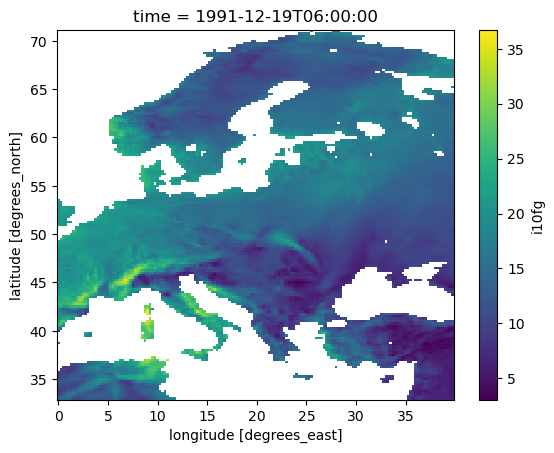

In [7]:
# Plot masked temperature on a map with coastlines


sorted_data = land_wind[specific_var].sortby(['longitude', 'latitude'])
sorted_data = sorted_data.assign_coords(time=time_landfall)
# Plot the sorted data
#sorted_data[:,:].plot()

sorted_data[:,0:160].plot()

# Show the plot
#plt.show()

In [10]:
import rioxarray

#land_wind.isel(time=0).rio.to_raster(f'{output_file}_eu_1991_test.tif')

# save the land_wind data as nc

land_wind.to_netcdf(f'{output_file}_eu_1991_test.nc')


In [3]:
input_path = '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF/ERA5/SL/'
output_path = '/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/cleaner_version/pre_processing/maps/wind_maps'
index = 37

wind_map.to_tiff(variable, storm_dates, input_path, output_path, index, level=0)

In [61]:
year = int(storm_dates['start_date'][index][:4])

dataset, specific_var = wind_map.process_data(variable, year, input_path, level=0)

land_sea_mask = xr.open_dataset('/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF/ERA5/SL/land_sea_mask/ERA5_2021-1_land_sea_mask.nc')
# remove the time dimension
land_sea_mask = land_sea_mask.sel(time='2021-01-01T00:00:00')

time_landfall = storm_dates['eu_landfall_date'][index]
time_end = storm_dates['end_date'][index]

#time_landfall = '1990-01-23T17:00:00.000000000'
#time_end = '1990-01-28T18:00:00.000000000'

# slice the gust data to the time of landfall to end of storm

global_storm = dataset.sel(time=slice(time_landfall, time_end))
global_first_storm_max = global_storm.max(dim='time')

#global_first_storm_max_eu = global_first_storm_max.roll(longitude=180).sel(latitude=slice(71, 33), longitude=slice(338, 40))
#global_first_storm_max_eu = global_first_storm_max_eu.roll(longitude=90, roll_coords='longitude')

land_wind = global_first_storm_max.where(land_sea_mask['lsm'] >= 0.5)
land_wind = land_wind.assign_coords(time=time_landfall)

storm_name_value = storm_dates['storm_name'][index]
storm_index_value = storm_dates['storm_index'][index]
storm_name = f'{storm_name_value}_{storm_index_value}'

#sorted_data = land_wind[specific_var].sortby(['longitude', 'latitude'])

land_wind['longitude'] = xr.where(land_wind['longitude'] > 180, land_wind['longitude'] - 360, land_wind['longitude'])

# Step 2: Sort the dataset by longitude to ensure it's in the right order
sorted_data = land_wind.sortby('longitude')

sorted_data_eu = sorted_data.sel(latitude=slice(71, 33), longitude=slice(-12, 40))
sorted_data_eu = sorted_data_eu.assign_coords(time=time_landfall)

# setting the projection
sorted_data_eu = sorted_data_eu.rio.write_crs("EPSG:4326")# sorted_data.rio.write_crs("EPSG:4326")

sorted_data_reprojected = sorted_data_eu.rio.reproject(
    sorted_data_eu.rio.crs,
    resolution=0.25  # Setting the desired pixel size
)

#sorted_data_reprojected.rio.to_raster(f'{output_path}/{storm_name}.tif')

In [62]:
sorted_data_eu

<xarray.Dataset> Size: 257kB
Dimensions:      (latitude: 153, longitude: 209)
Coordinates:
  * longitude    (longitude) float32 836B -12.0 -11.75 -11.5 ... 39.5 39.75 40.0
  * latitude     (latitude) float32 612B 71.0 70.75 70.5 ... 33.5 33.25 33.0
    time         <U19 76B '1999-12-26T01:00:00'
    spatial_ref  int64 8B 0
Data variables:
    i10fg        (latitude, longitude) float64 256kB nan nan nan ... 8.943 9.027

In [63]:
sorted_data_reprojected.rio.to_raster(f'{output_path}/{storm_name}.tif')